
# 二维卷积层

卷积神经网络（convolutional neural network）是含有卷积层（convolutional layer）的神经网络。本章中介绍的卷积神经网络均使用最常见的二维卷积层。它有高和宽两个空间维度，常用来处理图像数据。本节中，我们将介绍简单形式的二维卷积层的工作原理。
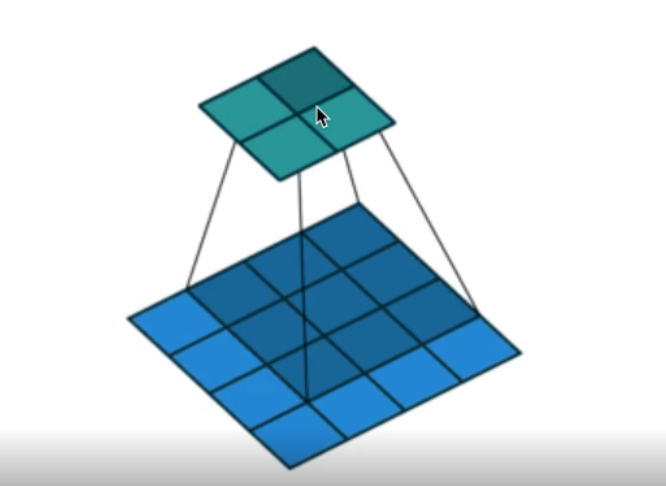


## 二维互相关运算

虽然卷积层得名于卷积（convolution）运算，但我们通常在卷积层中使用更加直观的互相关（cross-correlation）运算。在二维卷积层中，一个二维输入数组和一个二维核（kernel）数组通过互相关运算输出一个二维数组。
我们用一个具体例子来解释二维互相关运算的含义。如图5.1所示，输入是一个高和宽均为3的二维数组。我们将该数组的形状记为$3 \times 3$或（3，3）。核数组的高和宽分别为2。该数组在卷积计算中又称卷积核或过滤器（filter）。卷积核窗口（又称卷积窗口）的形状取决于卷积核的高和宽，即$2 \times 2$。图5.1中的阴影部分为第一个输出元素及其计算所使用的输入和核数组元素：$0\times0+1\times1+3\times2+4\times3=19$。

![二维互相关运算](../img/correlation.svg)

在二维互相关运算中，卷积窗口从输入数组的最左上方开始，按从左往右、从上往下的顺序，依次在输入数组上滑动。当卷积窗口滑动到某一位置时，窗口中的输入子数组与核数组按元素相乘并求和，得到输出数组中相应位置的元素。图5.1中的输出数组高和宽分别为2，其中的4个元素由二维互相关运算得出：

$$
0\times0+1\times1+3\times2+4\times3=19,\\
1\times0+2\times1+4\times2+5\times3=25,\\
3\times0+4\times1+6\times2+7\times3=37,\\
4\times0+5\times1+7\times2+8\times3=43.\\
$$

下面我们将上述过程实现在`corr2d`函数里。它接受输入数组`X`与核数组`K`，并输出数组`Y`。

In [27]:
from mxnet import autograd, nd
from mxnet.gluon import nn

def corr2d(X, K):  # 本函数已保存在d2lzh包中方便以后使用，输入数组X
    h, w = K.shape  #核数组K
    Y = nd.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1)) #输出数组Y，shape[0]行，shape[1]列,Y 2*2
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            print(X[i: i + h, j: j + w] )
            print((X[i: i + h, j: j + w] * K))
            Y[i, j] = (X[i: i + h, j: j + w] * K).sum()
    return Y

我们可以构造图5.1中的输入数组`X`、核数组`K`来验证二维互相关运算的输出。

In [28]:
X = nd.array([[0, 1, 2], [3, 4, 5], [6, 7, 8]])
K = nd.array([[0, 1], [2, 3]])
corr2d(X, K)


[[0. 1.]
 [3. 4.]]
<NDArray 2x2 @cpu(0)>

[[ 0.  1.]
 [ 6. 12.]]
<NDArray 2x2 @cpu(0)>

[[1. 2.]
 [4. 5.]]
<NDArray 2x2 @cpu(0)>

[[ 0.  2.]
 [ 8. 15.]]
<NDArray 2x2 @cpu(0)>

[[3. 4.]
 [6. 7.]]
<NDArray 2x2 @cpu(0)>

[[ 0.  4.]
 [12. 21.]]
<NDArray 2x2 @cpu(0)>

[[4. 5.]
 [7. 8.]]
<NDArray 2x2 @cpu(0)>

[[ 0.  5.]
 [14. 24.]]
<NDArray 2x2 @cpu(0)>



[[19. 25.]
 [37. 43.]]
<NDArray 2x2 @cpu(0)>

## 二维卷积层

二维卷积层将输入和卷积核做互相关运算，并加上一个标量偏差来得到输出。
卷积层的模型参数包括了卷积核和标量偏差。
在训练模型的时候，通常我们先对卷积核随机初始化，然后不断迭代卷积核和偏差。

下面基于`corr2d`函数来实现一个自定义的二维卷积层。
在构造函数`__init__`里我们声明`weight`和`bias`这两个模型参数。前向计算函数`forward`则是直接调用`corr2d`函数再加上偏差。

In [3]:
class Conv2D(nn.Block):
    def __init__(self, kernel_size, **kwargs):
        super(Conv2D, self).__init__(**kwargs)
        self.weight = self.params.get('weight', shape=kernel_size)
        self.bias = self.params.get('bias', shape=(1,))

    def forward(self, x):
        return corr2d(x, self.weight.data()) + self.bias.data()

卷积窗口形状为$p \times q$的卷积层称为$p \times q$卷积层。同样，$p \times q$卷积或$p \times q$卷积核说明卷积核的高和宽分别为$p$和$q$。


## 图像中物体边缘检测

下面我们来看一个卷积层的简单应用：检测图像中物体的边缘，即找到像素变化的位置。首先我们构造一张$6\times 8$的图像（即高和宽分别为6像素和8像素的图像）。它中间4列为黑（0），其余为白（1）。

In [4]:
X = nd.ones((6, 8))
X[:, 2:6] = 0
X


[[1. 1. 0. 0. 0. 0. 1. 1.]
 [1. 1. 0. 0. 0. 0. 1. 1.]
 [1. 1. 0. 0. 0. 0. 1. 1.]
 [1. 1. 0. 0. 0. 0. 1. 1.]
 [1. 1. 0. 0. 0. 0. 1. 1.]
 [1. 1. 0. 0. 0. 0. 1. 1.]]
<NDArray 6x8 @cpu(0)>

然后我们构造一个高和宽分别为1和2的卷积核`K`。当它与输入做互相关运算时，如果横向相邻元素相同，输出为0；否则输出为非0。

In [5]:
K = nd.array([[1, -1]])

下面将输入`X`和我们设计的卷积核`K`做互相关运算。可以看出，我们将从白到黑的边缘和从黑到白的边缘分别检测成了1和-1。其余部分的输出全是0。

In [6]:
Y = corr2d(X, K)
Y


[[ 0.  1.  0.  0.  0. -1.  0.]
 [ 0.  1.  0.  0.  0. -1.  0.]
 [ 0.  1.  0.  0.  0. -1.  0.]
 [ 0.  1.  0.  0.  0. -1.  0.]
 [ 0.  1.  0.  0.  0. -1.  0.]
 [ 0.  1.  0.  0.  0. -1.  0.]]
<NDArray 6x7 @cpu(0)>

由此，我们可以看出，卷积层可通过重复使用卷积核有效地表征局部空间。


## 通过数据学习核数组

最后我们来看一个例子，它使用物体边缘检测中的输入数据`X`和输出数据`Y`来学习我们构造的核数组`K`。我们首先构造一个卷积层，将其卷积核初始化成随机数组。接下来在每一次迭代中，我们使用平方误差来比较`Y`和卷积层的输出，然后计算梯度来更新权重。简单起见，这里的卷积层忽略了偏差。

虽然我们之前构造了`Conv2D`类，但由于`corr2d`使用了对单个元素赋值（`[i, j]=`）的操作因而无法自动求梯度。下面我们使用Gluon提供的`Conv2D`类来实现这个例子。

In [7]:
# 构造一个输出通道数为1（将在“多输入通道和多输出通道”一节介绍通道），核数组形状是(1, 2)的二维卷积层
conv2d = nn.Conv2D(1, kernel_size=(1, 2))
conv2d.initialize()

# 二维卷积层使用4维输入输出，格式为(样本, 通道, 高, 宽)，这里批量大小（批量中的样本数）和通道数均为1
X = X.reshape((1, 1, 6, 8))
Y = Y.reshape((1, 1, 6, 7))

# 自动求导
for i in range(10):
    # 默认条件下，MXNet不会自动记录和‘构建’用于求导的计算图，
    # 我们需要使用autograd里的record()函数来显式的要求MXNet记录我们需要求导的程序。
    with autograd.record():
        Y_hat = conv2d(X)
        l = (Y_hat - Y) ** 2
    l.backward()
    # 简单起见，这里忽略了偏差
    # 使用L2范数损失，并在更新的时候引入一个惩罚系数3e-2
    conv2d.weight.data()[:] -= 3e-2 * conv2d.weight.grad()
    if (i + 1) % 2 == 0:
        print('batch %d, loss %.3f' % (i + 1, l.sum().asscalar()))

batch 2, loss 4.949
batch 4, loss 0.831
batch 6, loss 0.140
batch 8, loss 0.024
batch 10, loss 0.004


可以看到，10次迭代后误差已经降到了一个比较小的值。现在来看一下学习到的核数组。

In [8]:
conv2d.weight.data().reshape((1, 2))


[[ 0.9895    -0.9873705]]
<NDArray 1x2 @cpu(0)>

可以看到，学到的核数组与我们之前定义的核数组`K`较接近。

## 互相关运算和卷积运算

实际上，卷积运算与互相关运算类似。为了得到卷积运算的输出，我们只需将核数组左右翻转并上下翻转，再与输入数组做互相关运算。可见，卷积运算和互相关运算虽然类似，但如果它们使用相同的核数组，对于同一个输入，输出往往并不相同。

那么，你也许会好奇卷积层为何能使用互相关运算替代卷积运算。其实，在深度学习中核数组都是学出来的：卷积层无论使用互相关运算或卷积运算都不影响模型预测时的输出。为了解释这一点，假设卷积层使用互相关运算学出图5.1中的核数组。设其他条件不变，使用卷积运算学出的核数组即图5.1中的核数组按上下、左右翻转。也就是说，图5.1中的输入与学出的已翻转的核数组再做卷积运算时，依然得到图5.1中的输出。为了与大多数深度学习文献一致，如无特别说明，本书中提到的卷积运算均指互相关运算。


## 特征图和感受野
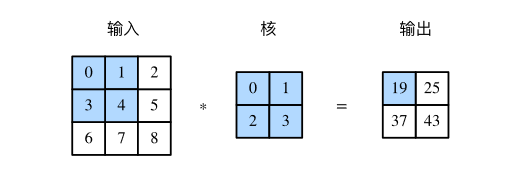

二维卷积层输出的二维数组可以看作是输入在空间维度（宽和高）上某一级的表征，也叫特征图（feature map）。影响元素$x$的前向计算的所有可能输入区域（可能大于输入的实际尺寸）叫做$x$的感受野（receptive field）。以图5.1为例，输入中阴影部分的四个元素是输出中阴影部分元素的感受野。我们将图5.1中形状为$2 \times 2$的输出记为$Y$，并考虑一个更深的卷积神经网络：将$Y$与另一个形状为$2 \times 2$的核数组做互相关运算，输出单个元素$z$。那么，$z$在$Y$上的感受野包括$Y$的全部四个元素，在输入上的感受野包括其中全部9个元素。

可见，我们可以通过更深的卷积神经网络使特征图中单个元素的感受野变得更加广阔，从而捕捉输入上更大尺寸的特征。

我们常使用“元素”一词来描述数组或矩阵中的成员。在神经网络的术语中，这些元素也可称为“单元”。当含义明确时，本书不对这两个术语做严格区分。


## 小结

* 二维卷积层的核心计算是二维互相关运算。在最简单的形式下，它对二维输入数据和卷积核做互相关运算然后加上偏差。
* 我们可以设计卷积核来检测图像中的边缘。
* 我们可以通过数据来学习卷积核。


## 练习

* 构造一个输入图像`X`，令它有水平方向的边缘。如何设计卷积核`K`来检测图像中水平边缘？如果是对角方向的边缘呢？
* 试着对我们自己构造的`Conv2D`类进行自动求梯度，会有什么样的错误信息？在该类的`forward`函数里，将`corr2d`函数替换成`nd.Convolution`类使得自动求梯度变得可行。
* 如何通过变化输入和核数组将互相关运算表示成一个矩阵乘法？
* 如何构造一个全连接层来进行物体边缘检测？



## 扫码直达[讨论区](https://discuss.gluon.ai/t/topic/6314)

![](../img/qr_conv-layer.svg)